In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# Exercise 04: Molecular dynamics

### DESCRIPTION OF THE SYSTEM
I am simulating **108** particles inside a cubic volume (the size depends on the density *rho* that is chosen as input. Initially, the particles are positioned in an FCC configuration, occupying half the side of the volume. 

*NOTE*: the particles' initial positions are written in a *config.xyz* file, in units of _side of the cube: this is important when setting the particle positions later in the code 

The interaction between 2 particles in a fluid is described by the Lennard-Jones potential: 
$$V(r)=4\epsilon\Big[\Big( \frac{\sigma}{r}\Big)^{12} - \Big( \frac{\sigma}{r} \Big) ^6\Big]$$ 
In which *r* is the distance between the particles, $\epsilon$ is the depth of the potential well and $\sigma$ is the cutoff radius, so the distance at which the particle interaction is assumed to be zero,i.e we are assuming that the interaction between particles in the fluid is short-ranged. <br>
This last hypothesis allows us to simulate particles in a lattice considering only their interaction with their closest neighbors, which will greatly simplify the system.

The system then is evolved moving the particles from their old positions to new ones that are determined in each step by the by the Verlet algorithm:
$$ \vec{r}(t+\delta t) = 2\vec{r}(t)-\vec{r}(t-\delta t) + \delta t^2 \vec{a}(t)
 $$
With the knoledge of the particle positions we can also infer their velocities:
$$ \vec{v}(t) = \frac{\vec{r}(t+\delta t)-\vec{r}(t-\delta t)}{\delta t ^2}+ \mathcal {O}(\delta t^2)$$
I am simulating the particles in an ideal gas state, so the initial conditions (which I am setting in the *input.dat* file and are being read by the *Initialize()* function) are set with low density and high temperature: 

SIMULATION_TYPE:      0   #Lennard Jones molecular dynamics	<br>
RESTART:                 0   #starts from configuration in config.xyz<br>
TEMP:                    2.0 <br>
NPART:                   108<br>
RHO:                     0.05<br>
R_CUT:                   5.0 #cutoff radius of Lennard-Jones potential<br>
DELTA:                   0.001<br>
NBLOCKS:                 20<br>
NSTEPS:                  20000<br>

## 04.1
**Include the calculation of the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, inside your Molecular Dynamics code by using data blocking to obtain single block averages, progressive average values and progressive uncertainties for $p(v^*,T^*)$.**

$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$ 

1. **Initialization**:  the *initialize()* and *initialize_properties()* functions are called. They read the *input.dat* file, which specifies the characteristics of the system, and the *properties.dat*, in which the measurable properties are listed. It also initializes the measurement vector, which contains each measurement at its specific index. <br> <br>For the Maxwell-Boltzmann distribution measurement, it is not only one one index but an interval that ranges from *_index_pofv* to *_index_pofv + _n_bins_v* where this last quantity is specified in the input properties file.  <br>
Since the bin number is fixed in input, by choosing the bin size I can determine how large is the velocity interval in which I want to sample the probability distribution. It is convenient to choose an interval that is significantly larger than the width of the gaussian ($\sqrt{T}$), but also not too large since the distribution tails rapidly go to zero as the velocity distances from the mean value. My choice was: `_bin_size_v = 4.0*sqrt(_temp)/(double)_n_bins_v`


2. **Equilibration:** the particles start in an FCC configuration in which their initial velocities are all set to zero, so of course in the beginning of the simulation their actual temperature will differ from the one that is given as input.<br>
For this reason I input a temperature ($T_{in}=1.8$) that is lower than the desired one ($T=2.0$)  and let the system evolve for 2500 steps, registering the temperature mesurement in a separate file.  Here are the results:


In [2]:
file= "/home/elisa/Scrivania/LSN/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/Equilibration.csv"
df1 = pd.read_csv(file,sep ="\t")
df1.head()

,Step,Temp
0,0,1.81
1,1,1.81
2,2,1.81
3,3,1.81
4,4,1.81


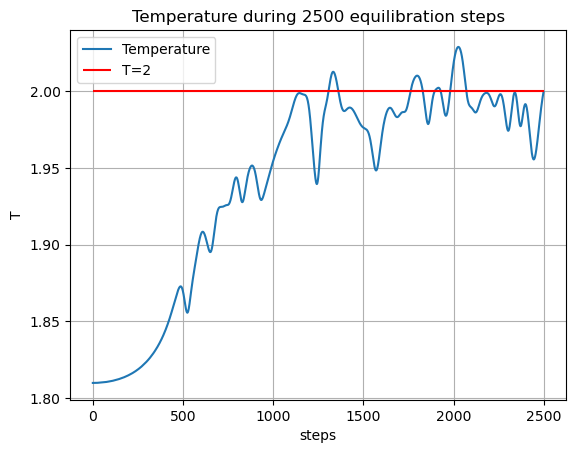

In [3]:
Neq_steps=len(df1['Step'])

plt.plot(df1['Step'],df1['Temp'],label = 'Temperature')
plt.hlines(2.0,0,Neq_steps,color='r',label = 'T=2')
plt.xlabel('steps')
plt.ylabel('T')
plt.legend()
plt.title(f'Temperature during {Neq_steps} equilibration steps')
plt.grid()
plt.show()

In [4]:
T=df1['Temp'][2499]
print(f'Equilibrium temperature: T={T}')

Equilibrium temperature: T=1.99951


From this plot I can see that after this process the temperature is stabilized, so the system is sufficiently in equilibrium to perform the measurement.

3. **Measurement setup:** measuring the Maxwell-Boltzmann means that at every simulation step I have to measurethe particle velocities and fill an histogram bin. This means that the measurement will not be registered in only one index, like for the other properties, but in a series of *n_bins_v* indices.<br>
Therefore, my first step was modifying the *initialize_properties* function: first, it checks if the property $P(v)$ is in the *properties.dat* file, and if its, it takes the bin number as input. The bin size is also chosen in this function as I said before. Then it creates the output file and increases the number of property indices by *_n_bins_v*.

4. **Measurement execution:** to perform the Maxwell-Boltzmann distribution measurement I modified the *measure()* function of the *system* class as follows: <br>

```c++
if (_measure_pofv){
vec velocities(_npart);
velocities.zeros();
for (int i=0; i<_npart;i++){   
  velocities (i) = sqrt(dot( _particle(i).getvelocity() , _particle(i).getvelocity() ));
  for (int j=0;j<_n_bins_v;j++){
    double v_inf=(j+1)*_bin_size_v;
    double v_sup = v_inf + _bin_size_v;
    if (velocities(i)>v_inf && velocities(i)<=v_sup) _measurement(_index_pofv+j) ++;
       
  }     
  }
} 

4. **Averages:** for every step of the simulation, at the end of the measurement phase the values of all th emeasured properties are added to the previous ones inside a *_block_av* vector. Then at the end of every block the *averages()* function is called,in which the progressive averages and sum averages, along with their respective error, are computed. In this function I added an *if* clause that  becomes active when measuring the particle velocity distribution, and stores the desired information into a file. I will now show the results that are in that file.

In [5]:
#first two lines of the file contain information about the bin size and initial distrinution (Maxwell-Boltzmann in this case)
file= "/home/elisa/Scrivania/LSN/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/pofv.csv"
with open (file) as f:
    distrib_type = f.readline()
    print(distrib_type)
    bin_size_line = f.readline()
    print (bin_size_line)
    bin_size = float(bin_size_line.split('\t', 1)[1])

INITIAL DISTRIBUTION	MB

BIN SIZE	0.179382



The file is structured as follows: starting from the first block, each row represents the average values and errors in each bin, so the first block will make up an histogram. Then there is a blank space, which is what divides the blocks and will be tken into account when reading the file with pandas, and the data that makes up the second histogram begins, and so on.

In [6]:
df = pd.read_csv(file,sep ="\t", skiprows=2, skip_blank_lines = False)
df.head()

,BIN,VMIN,VMAX,AVE,PROG_AVE_POFV,ERROR
0,0.0,0.179382,0.358763,0.0545,0.0545,0.0
1,1.0,0.358763,0.538145,0.2240,0.2240,0.0
2,2.0,0.538145,0.717527,0.5270,0.5270,0.0
3,3.0,0.717527,0.896908,1.5510,1.5510,0.0
4,4.0,0.896908,1.076290,4.9295,4.9295,0.0


In [12]:
def Maxwell_Boltzmann (v,T) : #theoretical Maxwell-Boltzmann distribution
    return 1/np.pow((2* np.pi*T),3/2)*4*np.pi*v*v*np.exp(-v*v/(2*T))

In [11]:
 #find block division
blank_rows = df[df.isnull().all(axis=1)].index
split_points = [-1] + list(blank_rows) + [len(df)] 

#build block histograms
histograms = []

for i in range(len(split_points) - 1):
    start = split_points[i] + 1
    end = split_points[i + 1]
    block = df.iloc[start:end].reset_index(drop=True)
    if not block.empty:
        histograms.append(block)

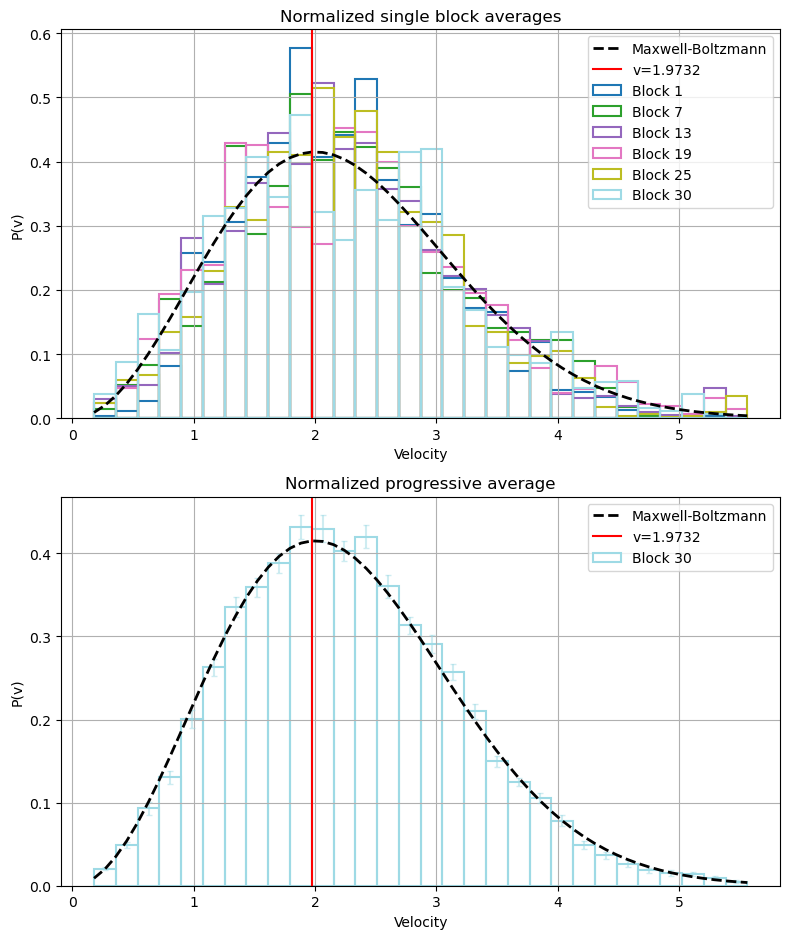

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

fig, ax = plt.subplots(2,1,figsize = (8,10))
ax = ax.flatten()
colors = plt.cm.tab20(np.linspace(0, 1, 30))

for i, h in enumerate(histograms):
    bin_centers = h['VMIN']+0.5*(h['VMAX']-h['VMIN'])
    v_all = np.concatenate((h['VMIN'].values, bin_centers, h['VMAX'].values))
    v_all = np.unique(v_all)  # Remove duplicates and sort

    # Maxwell-Boltzmann distribution
    mb_curve = Maxwell_Boltzmann(v_all, T)
    vmax = v_all[np.argmax(mb_curve)]

    if i%6==0 or i == 29:  #progressive average plots

        y = h['AVE'].values
    #normalization
        area = trapezoid(y, bin_centers)
        norm_y = y / area

        ax[0].bar(
            bin_centers, norm_y, width=bin_size, fill=False,
            edgecolor=colors[i], linewidth=1.5, label=f'Block {i+1}', 
            error_kw=dict(ecolor=colors[i], capsize=2, alpha=0.5)
        )
        if i==0: 
            ax[0].plot(v_all, mb_curve, 'k--', label='Maxwell-Boltzmann', linewidth=2)
            ax[0].axvline(vmax, color='red', linewidth=1.5,label= f'v={vmax}')
            
        ax[0].set_title('Normalized single block averages')
        ax[0].set_xlabel('Velocity')
        ax[0].set_ylabel('P(v)')
        ax[0].legend()
        ax[0].grid(True)

    
    if i==29: #cumulative average plot
        y = h['PROG_AVE_POFV'].values
        err = h['ERROR'].values
        #normalization
        area = trapezoid(y, bin_centers)
        norm_y = y / area
        norm_err = err / area  
        
        ax[1].bar(
            bin_centers, norm_y, width=bin_size, fill=False,
            edgecolor=colors[i], linewidth=1.5, label=f'Block {i+1}', yerr=norm_err,
            error_kw=dict(ecolor=colors[i], capsize=2, alpha=0.5)
        )
        ax[1].plot(v_all, mb_curve, 'k--', label='Maxwell-Boltzmann', linewidth=2)
        ax[1].axvline(vmax, color='red', linewidth=1.5,label= f'v={vmax}')
        ax[1].legend()
        ax[1].set_xlabel('Velocity')
        ax[1].set_ylabel('P(v)')
        ax[1].set_title('Normalized progressive average')
        ax[1].grid()
        
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 04.2
**Perform MD simulations via a Lennard-Jones model in the following conditions:**
- **gas phase: $\rho^\star = 0.05$, $T^\star \sim  2.0$ (cut-off radius: $r_c = 5.0$)**

**starting from a very low entropic initial configuration:**
1. **initial particle positions: fcc crystal occupying half of the simulation box in each dimension**
2. **initial velocity distribution:** $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$ 

**The goal is to show that, by evolving such initial condition via a Molecular Dynamics simulation, the velocity distribution tends to approximate the Maxwell–Boltzmann distribution.**

To show the convergence of the velocity distribution to the maxwell-boltzmann, I modified the *initialize_velocities()* function, that is called at the end of the initialization. This method sets each particle velocity to a fixed value around one of the 3 axes, that is chosen randomly, creatin a 3d delta distribution.Since the velocity squaredin every direction goes as the kinetic energy, which is proportional to the  temperature, I choose this fixed value as: $v_T=\sqrt{(vx^2+vy^2+vz^2)}= \sqrt{(3T)}$


```c++
    if (_vdistr==1){ //initial velocity distributionis chosen as input: 0 is Maxwell-Boltzmann, 1 is Dirac delta
      double vT= sqrt(3*_temp); //center of the distribution
      
      for (int i=0; i<_npart; i++){
        double r1 = _rnd.Rannyu(); //to choose sign of the velocity 
        double r2 =_rnd.Rannyu(); //to choose axis
        bool direction = true;
        
         if(r1 >=0.5) direction = false;

         if (r2<1./3. && direction == true) vx(i)=vT;
         if (r2<1./3. && direction == false) vx(i)=-vT;

         if (r2>1./3. && r2<2./3.&& direction == true) vy(i)=vT;
         if (r2>1./3. && r2<2./3. &&direction == false) vy(i)=-vT;

        if (r2>2./3. && direction == true) vz(i)=vT;
         if (r2>2./3. && direction == false) vz(i)=-vT;

         }


The measurement process is the same as before, the only difference is that now equilibration isn't needed anymore, since we want to see how the system evolves to equilibrium. Moreover, to better see the trend of the distribution approaching MB, it makes more sense to use a larger number of blocks(I used n_bl=100) with a smaller number of steps(n_steps=500).

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

#first two lines of the file contain information about the bin size and initial distrinution 
file= "/home/elisa/Scrivania/LSN/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/pofv.csv"
with open (file) as f:
    distrib_type = f.readline()
    print(distrib_type)
    bin_size_line = f.readline()
    print (bin_size_line)
    bin_size = float(bin_size_line.split('\t', 1)[1])

INITIAL DISTRIBUTION	DELTA

BIN SIZE	0.188562



In [35]:
df = pd.read_csv(file,sep ="\t", skiprows=2, skip_blank_lines = False)
df.head()

,BIN,VMIN,VMAX,AVE,PROG_AVE_POFV,ERROR
0,0.0,0.188562,0.377124,0.0,0.0,0.0
1,1.0,0.377124,0.565685,0.0,0.0,0.0
2,2.0,0.565685,0.754247,0.0,0.0,0.0
3,3.0,0.754247,0.942809,0.0,0.0,0.0
4,4.0,0.942809,1.131370,0.0,0.0,0.0


In [36]:
 #find block division
blank_rows = df[df.isnull().all(axis=1)].index
split_points = [-1] + list(blank_rows) + [len(df)] 

#build block histograms
histograms = []

for i in range(len(split_points) - 1):
    start = split_points[i] + 1
    end = split_points[i + 1]
    block = df.iloc[start:end].reset_index(drop=True)
    if not block.empty:
        histograms.append(block)

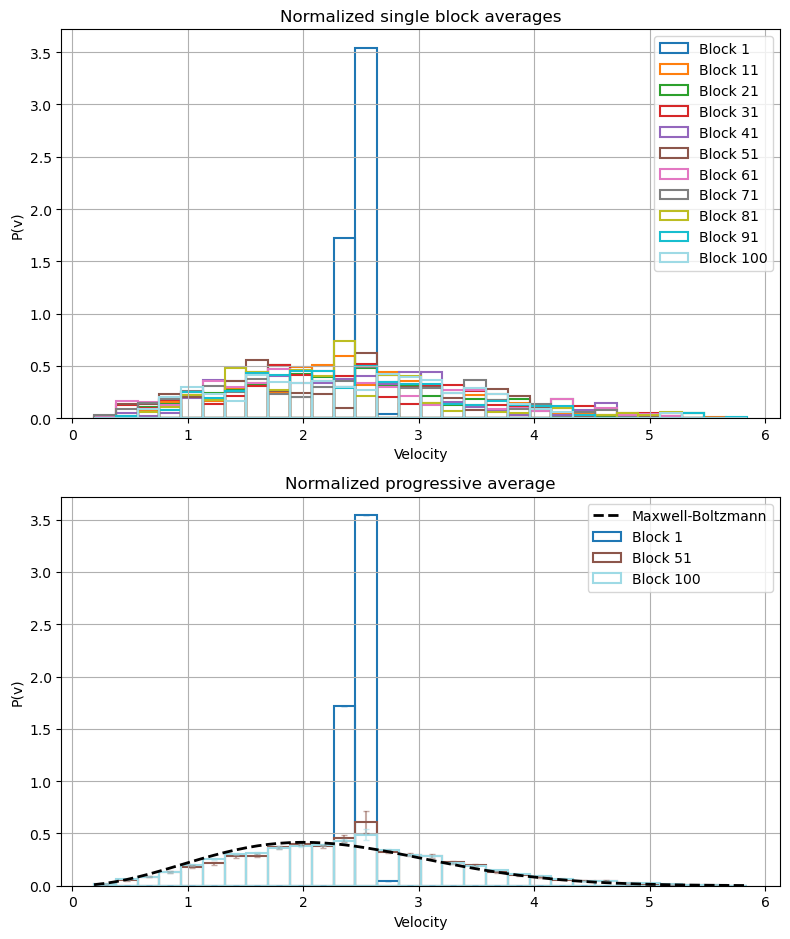

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

fig, ax = plt.subplots(2,1,figsize = (8,10))
ax = ax.flatten()
colors = plt.cm.tab20(np.linspace(0, 1, 100))

T=2

for i, h in enumerate(histograms):
    bin_centers = h['VMIN']+0.5*(h['VMAX']-h['VMIN'])
    v_all = np.concatenate((h['VMIN'].values, bin_centers, h['VMAX'].values))
    v_all = np.unique(v_all)  # Remove duplicates and sort

    # Maxwell-Boltzmann distribution
    mb_curve = Maxwell_Boltzmann(v_all, T)
    if i%10==0 or i == 99:  #progressive average plots

        y = h['AVE'].values
    #normalization
        area = trapezoid(y, bin_centers)
        norm_y = y / area

        ax[0].bar(
            bin_centers, norm_y, width=bin_size, fill=False,
            edgecolor=colors[i], linewidth=1.5, label=f'Block {i+1}', 
            error_kw=dict(ecolor=colors[i], capsize=2, alpha=0.5)
        )
        if i==6: 
           
            ax[0].plot(v_all, mb_curve, 'k--', label='Maxwell-Boltzmann', linewidth=2)
            
        ax[0].set_title('Normalized single block averages')
        ax[0].set_xlabel('Velocity')
        ax[0].set_ylabel('P(v)')
        ax[0].legend()
        ax[0].grid(True)
    
    if i==0 or i==50 or i==99: #cumulative average plot
        y = h['PROG_AVE_POFV'].values
        err = h['ERROR'].values
        #normalization
        area = trapezoid(y, bin_centers)
        norm_y = y / area
        norm_err = err / area  
        
        ax[1].bar(
            bin_centers, norm_y, width=bin_size, fill=False,
            edgecolor=colors[i], linewidth=1.5, label=f'Block {i+1}', yerr=norm_err,
            error_kw=dict(ecolor=colors[i], capsize=2, alpha=0.5)
        )
        if i==99: ax[1].plot(v_all, mb_curve, 'k--', label='Maxwell-Boltzmann', linewidth=2)
        
        ax[1].legend()
        ax[1].set_xlabel('Velocity')
        ax[1].set_ylabel('P(v)')
        ax[1].set_title('Normalized progressive average')
        ax[1].grid()
        
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
